# imports

In [ ]:
from main import *
import matplotlib.patches as patches

NOTEBOOK_ID = '15'
RUN_SHAP = False

Global seed set to 0


In [ ]:
amino_acids = ['R', 'K', 'D', 'E', 'Q', 'N', 'H', 'S', 'T', 'Y', 'C', 'W', 'M', 'A', 'I', 'L', 'F', 'V', 'P', 'G']

feature_dict = {
    'aliphatics':['I','V','L','A'],
    'aromatics':['W','F','Y'],
    'branching':['V','I','T'],
    'charged':['K','R','H','D','E'],
    'negatives':['D','E'],
    'phosphorylatables':['S','T','Y'],
    'polars':['R','K','D', 'E', 'Q', 'N', 'Y'],
    'hydrophobics':['W','F','L','V', 'I', 'C', 'M'],
    'positives':['K','R','H'],
    'sulfurcontaining':['M','C'],
    'tinys':['G','A','S','P']
 }
aa_dict = {}
for feature, amino_acids in feature_dict.items():
    for aa in amino_acids:
        if aa not in aa_dict:
            aa_dict[aa] = []
        aa_dict[aa].append(feature)

# analyze each member of new ensemble

In [3]:
harmonized_df = pd.read_pickle(f'{HARMONIZE_DIR}/04-results/esm2_t33_650M_UR50D-layer33-representations.pkl').query('dataset != "Mycocosm_Overlap"')#[['esm2_t33_650M_UR50D','linear_harmonized_activity']]
X = np.asarray([np.array(emb) for emb in harmonized_df['esm2_t33_650M_UR50D']])
y = harmonized_df['linear_harmonized_activity'].to_numpy()
thresh = harmonized_df['linear_harmonized_activity'].median()
dataset, idxs = split_dataset(X,y,thresh)
_,_,test_idx = idxs
harmonized_test_df = harmonized_df.loc[test_idx]

train,_,test = dataset
X_train, _, _ = train
X_test, _, y_test = test

model_names_df = pd.read_csv(f'{HAMMING_ENSEMBLE_DIR}/ADhunter_v2_ensemble_params_n20.csv')
model_names_df

,run,hidden_size,kernel_size,dilation,num_res_blocks,batch_size,pearson,file
0,4,32,3,3,0,512,0.806713,cnn_h32_k3_d3_r0_b512
1,598,32,4,5,9,256,0.800411,cnn_h32_k4_d5_r9_b256
2,837,32,4,10,2,128,0.800005,cnn_h32_k4_d10_r2_b128
3,1049,32,5,6,0,512,0.801618,cnn_h32_k5_d6_r0_b512
4,2763,32,9,5,2,256,0.802761,cnn_h32_k9_d5_r2_b256
5,3363,32,10,8,1,256,0.800812,cnn_h32_k10_d8_r1_b256
6,4013,64,4,3,10,256,0.800633,cnn_h64_k4_d3_r10_b256
7,4473,64,5,4,3,256,0.800221,cnn_h64_k5_d4_r3_b256
8,5068,64,6,7,1,256,0.801518,cnn_h64_k6_d7_r1_b256
9,5128,64,6,8,2,256,0.801076,cnn_h64_k6_d8_r2_b256


In [4]:
if RUN_SHAP:
    # random.seed(0)
    sample_idxs = random.sample(range(0,X_train.shape[0]),1000)
    for _,row in tqdm(model_names_df.iterrows(),total=len(model_names_df)):
        output_file = row['file'].replace('cnn','ADhunter_v2')
        if not os.path.isfile(f'{INTERPRETABILITY_DIR}/01-data/{output_file}_shap_values_n1000.csv'):
            model = ADhunterSystem_v2(embedding_size=X[0].shape[1],hidden=row['hidden_size'], kernel_size=row['kernel_size'], dilation=row['dilation'], num_res_blocks=row['num_res_blocks'],seq_len=X_test[0].shape[0])
            model.load_state_dict(torch.load(f'{UNCERTAINTY_DIR}/02-evaluate/02-models/{output_file}.pt'))
            explainer = shap.DeepExplainer(model, X_train[sample_idxs])
            shap_values = explainer.shap_values(X_test)
            shap_values = np.mean(shap_values,-1)
            shap_df = pd.DataFrame(shap_values).reset_index().melt(id_vars='index',var_name='position',value_name='SHAP_value')
            shap_df.to_csv(f'{INTERPRETABILITY_DIR}/01-data/{output_file}_shap_values_n1000.csv')

In [5]:
shap_df = None
for _,row in tqdm(model_names_df.iterrows(),total=len(model_names_df)):
    output_file = row['file'].replace('cnn','ADhunter_v2')
    tmp_df = pd.read_csv(f'{INTERPRETABILITY_DIR}/01-data/{output_file}_shap_values_n1000.csv').drop(columns=['Unnamed: 0'])
    tmp_df['model'] = output_file
    shap_df = pd.concat([shap_df, tmp_df]).reset_index(drop=True)
flat_shap_df = shap_df.groupby(['index','position'])['SHAP_value'].mean().reset_index()

aa_df = harmonized_test_df.copy()[['AAseq','linear_harmonized_activity']].reset_index(drop=True)
aa_df = aa_df['AAseq'].apply(lambda x: pd.Series(list(x))).reset_index().melt(id_vars='index',var_name='position',value_name='AA')
merged_df = aa_df.merge(flat_shap_df,on=['index','position'])

100%|██████████| 20/20 [00:01<00:00, 18.37it/s]


## evaluate AAs across ensemble 

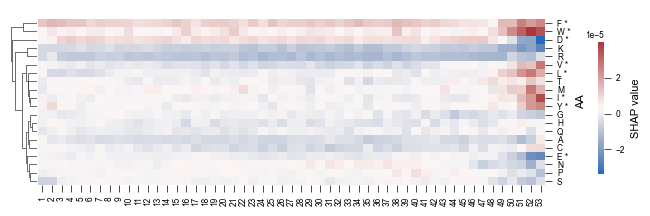

In [6]:
aa_mean = merged_df.groupby(['position','AA'])['SHAP_value'].mean()
aa_sum = merged_df.groupby(['position','AA'])['SHAP_value'].sum()
aa_norm = aa_mean/aa_sum
tmp_df = aa_mean.reset_index().pivot(index='AA',columns='position',values='SHAP_value').fillna(0.0)
tmp_df.columns = list(range(1,54))
tmp_df = tmp_df.rename(index={'D':'D *','E':'E *','F':'F *','W':'W *','L':'L *','Y':'Y *','I':'I *','V':'V *'})

g = sns.clustermap(tmp_df,
            cmap=sns.color_palette("vlag", as_cmap=True), 
            xticklabels=True,yticklabels=True,cbar_kws=dict(label='SHAP value'),col_cluster=False,figsize=(6,2.2),dendrogram_ratio=(0.05),cbar_pos=(1, 0.2, 0.01, 0.6))
plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-aa_shap_heatmap_ensemble.svg',bbox_inches='tight',transparent=True)

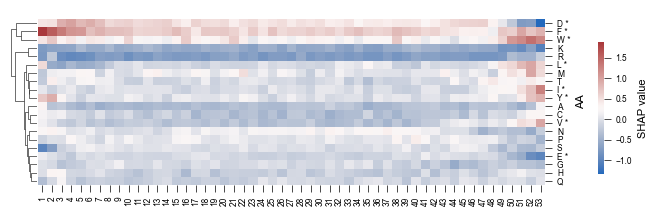

In [16]:
z_df = merged_df.groupby('position')['SHAP_value'].transform(lambda x: (x - x.mean()) / x.std())
merged_df['SHAP_z'] = z_df
tmp_df = merged_df.pivot_table(index='AA', columns='position', values='SHAP_z', aggfunc='mean').fillna(0.0)
tmp_df.columns = list(range(1,54))
tmp_df = tmp_df.rename(index={'D':'D *','E':'E *','F':'F *','W':'W *','L':'L *','Y':'Y *','I':'I *','V':'V *'})

g = sns.clustermap(tmp_df,
            cmap=sns.color_palette("vlag", as_cmap=True), 
            xticklabels=True,yticklabels=True,cbar_kws=dict(label='SHAP value'),col_cluster=False,figsize=(6,2.2),dendrogram_ratio=(0.05),cbar_pos=(1, 0.2, 0.01, 0.6))
plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-aa_shap_heatmap_ensemble.svg',bbox_inches='tight',transparent=True)

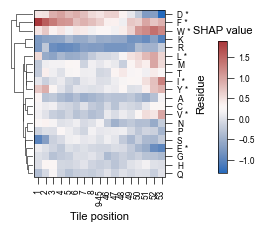

In [8]:
from scipy.cluster.hierarchy import linkage

mean_tmp_df = pd.concat([tmp_df.iloc[:,:8],tmp_df.iloc[:, 8:45].median(axis=1),tmp_df.iloc[:,45:]],axis=1)
mean_tmp_df = mean_tmp_df.rename(columns={0:'9-45'})
mean_tmp_df = mean_tmp_df.rename(index={'D':'D *','E':'E *','F':'F *','W':'W *','L':'L *','Y':'Y *','I':'I *','V':'V *'})
row_linkage = linkage(tmp_df.values, method='average', metric='euclidean')
g = sns.clustermap(mean_tmp_df,
                   cmap=sns.color_palette("vlag", as_cmap=True),
                   row_linkage=row_linkage,
                   xticklabels=True,
                   yticklabels=True,
                   col_cluster=False,
                   figsize=(2.2,2.2),
                   dendrogram_ratio=(0.15,0),
                   cbar_pos=(1.0, 0.2, 0.04, 0.6))

g.cax.set_title("SHAP value", loc='center')
g.ax_heatmap.set_xlabel("Tile position")
g.ax_heatmap.set_ylabel("Residue")
pos = g.ax_heatmap.get_position()
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
rect = patches.Rectangle(
    (pos.x0, pos.y0),
    pos.width,
    pos.height,
    linewidth=0.5,
    edgecolor='black',
    facecolor='none',
    transform=g.fig.transFigure,
    zorder=10
)
g.fig.patches.append(rect)

for spine in g.cax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(0.5)

plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-aa_shap_heatmap_ensemble_mean.svg',format='svg',bbox_inches='tight',transparent=True)

## evaluate AAs mapped to descriptors across ensemble

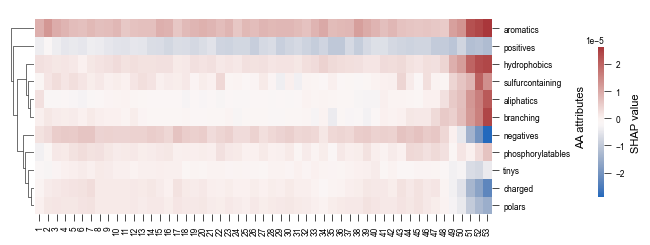

In [ ]:
# merged_df['AA_attributes'] = merged_df['AA'].map(aa_dict)

# tmp_df =  merged_df.explode('AA_attributes').groupby(['position','AA_attributes'])['SHAP_value'].mean()
# tmp_df = tmp_df.reset_index().pivot(index='AA_attributes',columns='position',values='SHAP_value').fillna(0.0)
# tmp_df.columns = list(range(1,54))
# tmp_df.index.name = 'AA attributes'

# g = sns.clustermap(tmp_df,
#             cmap=sns.color_palette("vlag", as_cmap=True), 
#             xticklabels=True,yticklabels=True,cbar_kws=dict(label='SHAP value'),col_cluster=False,figsize=(6,2.5),dendrogram_ratio=(0.05),cbar_pos=(1, 0.2, 0.01, 0.6))

# plt.xticks(rotation=0)
# plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-range_shap_heatmap_ensemble.png',dpi=400,bbox_inches='tight',transparent=False)

## evaluate strong activators across ensemble

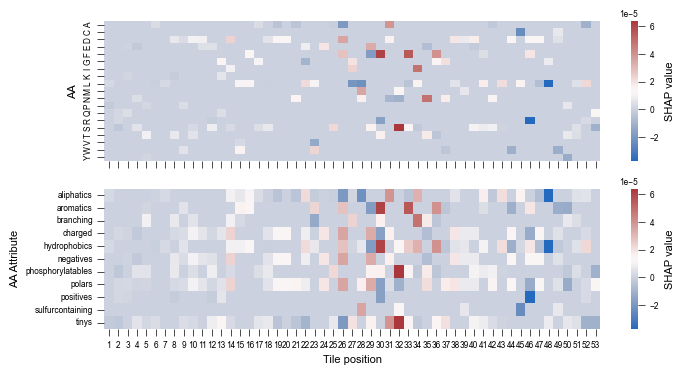

In [10]:
strong_thresh = harmonized_test_df['linear_harmonized_activity_scaled'].mean() + harmonized_test_df['linear_harmonized_activity_scaled'].std()
strong_df = harmonized_test_df[harmonized_test_df['linear_harmonized_activity_scaled'] > strong_thresh]
strong_shap_df = merged_df[merged_df['index'].isin(strong_df.index)].copy()
strong_shap_df

strong_aa_mean = strong_shap_df.groupby(['position','AA'])['SHAP_value'].mean()
attribute_mean = strong_shap_df.explode('AA_attributes').groupby(['position','AA_attributes'])['SHAP_value'].mean()

fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(8,4),sharex=True)

g = sns.heatmap(strong_aa_mean.reset_index().pivot(index='AA',columns='position',values='SHAP_value').fillna(0.0),
                cmap=sns.color_palette("vlag", as_cmap=True), xticklabels=True,yticklabels=True,ax=axes[0],cbar_kws=dict(label='SHAP value'))
g.set(xlabel=None)
g = sns.heatmap(attribute_mean.reset_index().pivot(index='AA_attributes',columns='position',values='SHAP_value').fillna(0.0),
            cmap=sns.color_palette("vlag", as_cmap=True), 
            xticklabels=True,yticklabels=True,ax=axes[1],cbar_kws=dict(label='SHAP value'));
g.set(ylabel='AA Attribute',xlabel='Tile position',xticklabels=range(1,54))
plt.xticks(rotation=0)

plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-strong_shap_heatmap_ensemble.png',dpi=400,bbox_inches='tight',transparent=False)


In [13]:
z_df

424       0.169680
437       0.904304
1393     -1.073984
2998      0.587962
3011     -1.154635
            ...   
131711   -0.125898
132667   -0.931089
134272    0.703676
134285    0.441024
135241   -1.144700
Name: SHAP_value, Length: 159, dtype: float64

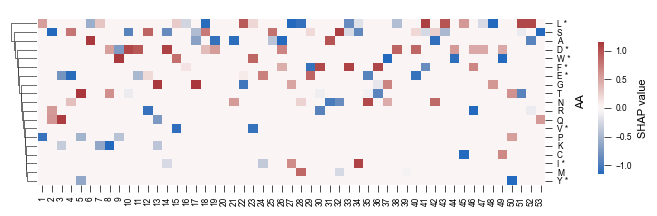

In [15]:
strong_thresh = harmonized_test_df['linear_harmonized_activity_scaled'].mean() + harmonized_test_df['linear_harmonized_activity_scaled'].std()
strong_df = harmonized_test_df[harmonized_test_df['linear_harmonized_activity_scaled'] > strong_thresh]
strong_shap_df = merged_df[merged_df['index'].isin(strong_df.index)].copy()

z_df = strong_shap_df.groupby('position')['SHAP_value'].transform(lambda x: (x - x.mean()) / x.std())
merged_df['SHAP_z'] = z_df
tmp_df = merged_df.pivot_table(index='AA', columns='position', values='SHAP_z', aggfunc='mean').fillna(0.0)
tmp_df.columns = list(range(1,54))
tmp_df = tmp_df.rename(index={'D':'D *','E':'E *','F':'F *','W':'W *','L':'L *','Y':'Y *','I':'I *','V':'V *'})

g = sns.clustermap(tmp_df,
            cmap=sns.color_palette("vlag", as_cmap=True), 
            xticklabels=True,yticklabels=True,cbar_kws=dict(label='SHAP value'),col_cluster=False,figsize=(6,2.2),dendrogram_ratio=(0.05),cbar_pos=(1, 0.2, 0.01, 0.6))
plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-aa_shap_heatmap_ensemble_strong.svg',bbox_inches='tight',transparent=True)
